In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import xgboost as xgb

train = pd.read_csv("../input/statistical-learning-sapienza-spring-2022/train.csv")
test = pd.read_csv("../input/statistical-learning-sapienza-spring-2022/test.csv")

# Preprocessing

test_id = test["id"]

train.drop(columns = ["id"], inplace = True)
test.drop(columns = ["id"], inplace = True)

new_train = train.drop(columns = ["y"])
y_train = train["y"]

#print(train.shape)
#print(test.shape)

#print(train.describe())

#print(new_train.isnull().values.any())
#print(sorted(new_train.isnull().sum()))

new_train = new_train.fillna(value=np.mean(new_train)) # Filling missing values with column means (test NAs are filled with corresponding training set column means)
test = test.fillna(value=np.mean(new_train))

#print(train["y"].value_counts())

coeffs_var = []

for col in train.columns:
    try: coeffs_var.append(train[col].std()/(train[col].mean()))
    except Exception: continue

#print(min(coeffs_var))

#new_train.drop(columns = ["month", "day"], inplace = True)
#test.drop(columns = ["month", "day"], inplace = True)

# Centering columns
# new_train = (new_train - np.mean(new_train)) / np.std(new_train)
# test = (test - np.mean(new_train)) / np.std(new_train)

# new_train = pd.get_dummies(new_train)
# test = pd.get_dummies(test)

The main idea that guided our workflow was to extract relevant insights from the data of the 4 variables for which we had temporal values (SP, CS, FCD, AL). We ended up building few custom new features, by employing some standard statistical functionals, in order to obtain what we though could have been useful summaries of the whole data distribution. During the 48 hours we came up with several ideas, both in terms of possible new features and approaches (data preprocessing/models); most of them were implemented and the ones that didn't seem to provide any additional improvement to the model accuracy (in terms of the F1-Score) were discarded.

The features that ended up in our final model draft:

* Mean of the 60 values of the SP, CS, FCD and AL variables
* The Coefficient of variation (std / mean) of the 60 values of the above variables. From the data exploration, we saw that oftentimes these variables presented values extremely similar in consecutive steps (oftentimes equal); we therefore thought that the Coefficient of variation could provide a significant insight about the variability of the data *(variability is information!)*
* The starting value of each of these variables
* The difference between the first and the last values (at time t=1 and t=60) of the CS and AL variables

In [33]:
# Build training and set dataset (new features)

temp_train_1 = new_train.iloc[:,:3] # from_start, month, day columns

temp_train_1['sp_start'] = new_train["sp.1"] # SP value at time t=1

temp_train_1['sp_mean'] = new_train.iloc[:,3:63].mean(axis=1) # SP mean (over 60 seconds)

temp_train_1['sp_coeff_var'] = new_train.iloc[:,3:63].std(axis=1)/new_train.iloc[:,4:63].mean(axis=1) # SP Coefficient of variation

temp_train_1['cs_start'] = new_train["cs.1"] # CS value at time t=1

temp_train_1['cs_mean'] = new_train.iloc[:,63:123].mean(axis=1) # CS mean (over 60 seconds)

temp_train_1['cs_coeff_var'] = new_train.iloc[:,63:123].std(axis=1)/new_train.iloc[:,64:123].mean(axis=1) # CS Coefficient of variation

temp_train_1['cs_diff'] = new_train["cs.60"]-new_train["cs.1"] # CS (End value - Start value)

temp_train_1['fcd_start'] = new_train["fcd.1"] # FCD value at time t=1

temp_train_1['fcd_mean'] = new_train.iloc[:,123:183].mean(axis=1) # FCD mean (over 60 seconds)

temp_train_1['fcd_coeff_var'] = new_train.iloc[:,123:183].std(axis=1)/new_train.iloc[:,124:183].mean(axis=1) # FCD Coefficient of variation

temp_train_1['al_start'] = new_train["al.1"] # AL value at time t=1

temp_train_1['al_mean'] = new_train.iloc[:,183:].mean(axis=1) # AL mean (over 60 seconds)

temp_train_1['al_coeff_var'] = new_train.iloc[:,183:].std(axis=1)/new_train.iloc[:,184:].mean(axis=1) # AL Coefficient of variation

temp_train_1['al_diff'] = new_train["al.60"]-new_train["al.1"] # CS (End value - Start value)

new_train_2 = temp_train_1

temp_test_1 = test.iloc[:,:3]
temp_test_1['sp_start'] = test["sp.1"]
temp_test_1['sp_mean'] = test.iloc[:,3:63].mean(axis=1)
temp_test_1['sp_coeff_var'] = test.iloc[:,3:63].std(axis=1)/test.iloc[:,4:63].mean(axis=1)
temp_test_1['cs_start'] = test["cs.1"]
temp_test_1['cs_mean'] = test.iloc[:,63:123].mean(axis=1)
temp_test_1['cs_coeff_var'] = test.iloc[:,63:123].std(axis=1)/test.iloc[:,64:123].mean(axis=1)
temp_test_1['cs_diff'] = test["cs.60"]-test["cs.1"]
temp_test_1['fcd_start'] = test["fcd.1"]
temp_test_1['fcd_mean'] = test.iloc[:,123:183].mean(axis=1)
temp_test_1['fcd_coeff_var'] = test.iloc[:,123:183].std(axis=1)/test.iloc[:,124:183].mean(axis=1)
temp_test_1['al_start'] = test["al.1"]
temp_test_1['al_mean'] = test.iloc[:,183:].mean(axis=1)
temp_test_1['al_coeff_var'] = test.iloc[:,183:].std(axis=1)/test.iloc[:,184:].mean(axis=1)
temp_test_1['al_diff'] = test["al.60"]-test["al.1"]
new_test_2 = temp_test_1

In [34]:
new_train = new_train_2
test = new_test_2

In [35]:
# One-Hot encoding of categorical variables (Month and Day)

new_train = pd.get_dummies(new_train)
test = pd.get_dummies(test)

Due to the nature of the problem (Multi-Class Classification where the different classes presented an intrinsic order), we decided to approach it as a Regression problem.

We built custom functions in order to cast the class labels to numbers and viceversa at the scoring and at the predicting stage. The casting function was realized in such a way that the resulting numbers where equidistant (since we wanted them to resemble the class structures); also the Zone-0, for which we had no precise HR information coming from the dataset description, was subject to the same rules. The actual value distribution was chosen via a grid-search approach: we in fact noticed that picking numbers of different magnitudes did impact the final model accuracy (we are aware that this is something rather odd and rarely happens with most well-known models, but the combination of our modelling of the problem and the model chosen - XGBoost - actually required further tuning).

The values that made it to the final draft in the end where the ones corresponding to the mean of the percentage values at the boundaries of the original intervals (multiplied by 100).

We came up with our custom scorer, that performed the conversion from numbers back to classes and computed the F1_weighted score. We went for the "weighted" version, which alters the default "macro" measure in order to account for label imbalance (we did in fact observe that only few observations were labelled with the "Zone-0" and "Zone-1" classes)

In [36]:
def myclass(x):
    if(x<=50): return "Zone-0"
    elif(x<=60): return "Zone-1"
    elif(x<=70): return "Zone-2"
    elif(x<=80): return "Zone-3"
    elif(x<=90): return "Zone-4"
    else: return "Zone-5"

def mynumber(x):
    if(x=="Zone-0"): return 45
    elif(x=="Zone-1"): return 55
    elif(x=="Zone-2"): return 65
    elif(x=="Zone-3"): return 75
    elif(x=="Zone-4"): return 85
    else: return 95

def myf1scorer(pred,actual,avg="weighted"):
    class_pred = [myclass(x) for x in pred]
    actual_pred = [myclass(x) for x in actual]
    return f1_score(actual_pred,class_pred,average=avg)

myscorer = make_scorer(myf1scorer, greater_is_better=True)

y_train = [mynumber(x) for x in y_train]

print(new_train.shape)

(12997, 31)


The final dataset presented 31 features (far less than the original 243)

The model selected for the final draft was eXtremeGradientBoosting regressor.

The first approach to the problem was via another (well-known) tree-based model: Random Forest. We initially followed this path since we are aware that those models are extremely flexible in terms of range of problems they are able to address with a very shallow tuning, and are therefore often our ice-breaking choice. Having observed fairly good results in terms of accuracy in the early attempts, we decided to stick with tree-based models, and focused our attention on XGB, since we believed that applying the *boosting* technique to our few, custom built features could provide satisfactory outcomes.

The tuning phase was carried out following both a grid-search and a manual, local parameter optimization approach. While the model did not require too much time to train at each iteration, it did however need for a fine-grained tuning in order to perform well. XGB presents a fairly large number of hyperparameters that can be tuned; we only addressed the ones we thought could affect accuracy under our settings.

Our final choices are listed below:

* Booster: dart (Tree-based)
* Eta (Learning rate): 0.092 
* Max Depth (of a tree): 9
* Lambda (L2 regularization term): 0.22
* Alpha (L1 regularization term): 1.5*(1e-5)
* Gamma (min_split_loss): 1e-4
* Min_child_weight (minimum number of instances needed to be in each node): 0 (Extremely not-conservative)

The model was trained via 5-fold CV; the fold error was computed using the custom scorer

In [37]:
random.seed(42)

xgb = xgb.XGBRegressor()
pipeline = Pipeline(steps=[("XGB", xgb)])
param_grid = {"XGB__booster": ["dart"], "XGB__eta": [0.092], "XGB__max_depth": [9], "XGB__lambda":[0.22],"XGB__alpha":[1.5*(1e-5)], "XGB__gamma": [1e-4], "XGB__min_child_weight":[0]}
search = GridSearchCV(pipeline, param_grid,n_jobs=-1,cv=5, scoring=myscorer, verbose=3)
search.fit(new_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_score_)
print(search.best_params_)
pred = search.predict(test)
pred = [myclass(x) for x in pred]
out_df = pd.DataFrame.from_dict({"id": test_id, "target": pred})
out_df.to_csv(r"./XGB.csv", index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameter (CV score=0.738):
0.7378132493505627
{'XGB__alpha': 1.5000000000000002e-05, 'XGB__booster': 'dart', 'XGB__eta': 0.092, 'XGB__gamma': 0.0001, 'XGB__lambda': 0.22, 'XGB__max_depth': 9, 'XGB__min_child_weight': 0}


<AxesSubplot:>

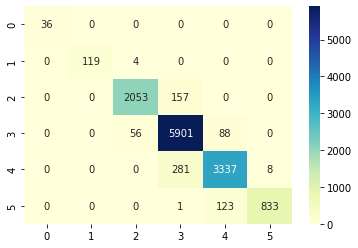

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


sns.heatmap(confusion_matrix([myclass(x) for x in y_train],[myclass(x) for x in search.predict(new_train)]), annot=True, cmap="YlGnBu", fmt='g')

The final model exhibited a 0.738 CV F1-score on the training set. When the predicted output was submitted to the Kaggle competition, the score on the "public" portion of the test set was even higher (relieving us of our main concern: overfitting while training).

The confusion matrix shows the performance of the model on the training set. XGB behaved extremely well in predicting the least frequent classes "Zone-0" and "Zone-1", while most of the incorrect predictions find their true value in the most frequent classes "Zone-3" and "Zone-4" (which is rather reasonable). In addition, basically all the incorrect values are actually classified in a Zone adjacent to the true one, which is a significant point of strength for our model.

The model was able to achieve a fairly good accuracy with only a small set of custom built features; we are confident it could be possible to increase it even further with a small effort by applying domain-specific knowledge () in order to realize even more informative features (we did try during the second day of work, but failed miserabily due to lack of the aforementioned knowledge :) )

**What we tried during the 48hrs and didn't end up in our final draft (A.K.A the long TBD silence..)**

- Feature Scaling/Normalizing (usually not required by tree-based models)
- Handling categorical non-target features differently:
       - Months: dropping them, encoding with custom functions (3 groups based on climate/seasons - both as categories and as numbers; replacing them with sin and cos values in order to account for cyclicality)

In [ ]:
def heat(x):
    if(x=="Dec" or x=="Jan" or x=="Feb"): return "Cold"
    elif(x=="Jun" or x=="Jul" or x=="Aug"): return "Hot"
    else: return "Warm"

def month_num(x):
    months = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,"Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}
    months_num = []
    for el in x:
        months_num.append(months[el])
    return np.array(months_num)

temp_train_1['month_sin'] = np.sin((month_num(new_train["month"])-1)(2.np.pi/12))
temp_train_1['month_cos'] = np.cos((month_num(new_train["month"])-1)(2.np.pi/12))


* Dimensionality Reduction: kPCA
* Different models:
    - Regression: SVR, Random Forest
    - Classification: Random Forest Classifier, OneVsRestClassifier + XGBClassifier()
* Adding different custom features: higher order moments (3,4), quantiles, combinations of SP, CD, FDC and AL in order to come up with some metric tracking "effort level" (e.g. Appoximating Steps Per Minute with the equation: (CD + FDC)*2) 
* Time-window approach: aggregating the 60 measurements via a sliding window approach (of different sizes - overlapping and not), in a "time-series analysis fashion"

In [ ]:
def third_mom(x):
    col = []
    for i in range(x.shape[0]):
        col.append(moment(x.iloc[i,:],moment=3))
    return col

#####

values_tr = []
values_te = []

for t in range(new_train.shape[0]):
    values_train = []
    values_test = []
    windowsize = 10
    for i in range(int(60/windowsize)):
        k=183+windowsize*i
        for f in range(windowsize):
            values_train.append(new_train.iloc[t,k+winsize-1]/new_train.iloc[t,k])
            values_test.append(test.iloc[t,k+winsize-1]/test.iloc[t,k])
    values_tr.append(np.array(values_train)*new_train.iloc[t,3:63]*(new_train.iloc[t,63:123]+new_train.iloc[t,123:183])*2)
    values_te.append(np.array(values_test)*test.iloc[t,3:63]*(test.iloc[t,63:123]+test.iloc[t,123:183])*2)

#####
    
for t in range(new_train.shape[0]):
    values_train = []
    for i in range(int(60/windowsize)):
        k=183+windowsize*i
        for f in range(windowsize):
            values_train.append(new_train.iloc[t,k+windowsize-1]-new_train.iloc[t,k])
    #values_tr.append(np.array(values_train)*np.array(new_train.iloc[t,3:63])*(np.array(new_train.iloc[t,63:123])+np.array(new_train.iloc[t,123:183]))*2)
    delta_al = np.array(values_train)
    spm = (np.array(new_train.iloc[t,63:123])+np.array(new_train.iloc[t,123:183]))*2
    row = []
    for i in range(len(delta_al)):
        if delta_al[i]>=0: row.append(delta_al[i]/spm[i])
        else: row.append(delta_al[i]*spm[i])
    values_tr.append(np.array(row))
    
#####

for t in range(test.shape[0]):
    values_test = []
    for i in range(int(60/windowsize)):
        k=63+windowsize*i
        for f in range(windowsize):
            values_test.append(2*(test.iloc[t,k+windowsize-1]+test.iloc[t,k+60+windowsize-1])-2*(test.iloc[t,k]+test.iloc[t,k+60]))
    values_te.append(np.array(values_test))